In [85]:
import torch.nn as nn
import torch
import torch.utils.data as data
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import os
import scipy.io as sio
from collections import defaultdict, deque
import datetime
import time
import torch.distributed as dist
import errno
import torch.nn.functional as F
import math
import random
from matplotlib import pyplot as plt
from torchvision import transforms

In [86]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{value:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [102]:
# transform
def transform_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return transform

# create dataset class
class channel_dataset(data.Dataset):
    def __init__(self, data_path, use_noise: bool = False, is_train: bool = True, cnn_out_path: str = None):
        super(channel_dataset, self).__init__()
        self.data_path = data_path
        self.data = sio.loadmat(data_path)
        self.use_noise = use_noise
        self.is_train = is_train

        self.cnn_out_path = cnn_out_path
        self.cnn_out = np.load(self.cnn_out_path)
        self.cnn_out = ((self.cnn_out - self.cnn_out.min()) / (self.cnn_out.max() - self.cnn_out.min()) * 230 + 10).astype(np.uint8).reshape(-1, 8, 16)
        # self.cnn_out = ((self.cnn_out + 256) / (458) * 230 + 10).astype(np.uint8).reshape(-1, 8, 16)
        # self.cnn_out = ((self.cnn_out + 215) / (428) * 230 + 10).astype(np.uint8).reshape(-1, 8, 16)

        self.trans = transform_data()

        # self.tx_data = self.data['Xt_train'] if self.is_train else self.data['Xt_val']
        # self.rx_data = self.data['rx_Xt_train'] if self.is_train else self.data['rx_Xt_val']
        # self.rx_data_noised = self.data['rx_Xt_noise_train'] if self.is_train else self.data['rx_Xt_noise_val']
        # self.symbols = self.data['data_train'] if self.is_train else self.data['data_val']
        # self.symbols = np.reshape(self.symbols, (-1))

        self.tx_data = self.data['Xt'] 
        self.rx_data_noised = self.data['rx_Xt_noise'] 
        self.symbols = self.data['qam_symbols'] 
        self.symbols = np.reshape(self.symbols, (-1))

        self.tx_data = self.tx_data.astype(np.float32)
        # self.rx_data = self.rx_data.astype(np.float32)
        self.rx_data_noised = self.rx_data_noised.astype(np.float32)

        # use min-max normalize to rescale the data to int val of [10, 240]
        self.tx_data = (self.tx_data - np.min(self.tx_data)) / (np.max(self.tx_data) - np.min(self.tx_data)) * 230 + 10
        # self.rx_data = (self.rx_data - np.min(self.rx_data)) / (np.max(self.rx_data) - np.min(self.rx_data)) * 230 + 10
        self.rx_data_noised = (self.rx_data_noised - np.min(self.rx_data_noised)) / (np.max(self.rx_data_noised) - np.min(self.rx_data_noised)) * 230 + 10

        self.tx_data = self.tx_data.astype(np.uint8)
        # self.rx_data = self.rx_data.astype(np.uint8)
        self.rx_data_noised = self.rx_data_noised.astype(np.uint8)

        # transfer the tx_data's each element into 8-bits binary digits, as the range is in [0, 255]
        self.tx_data_label = np.unpackbits(self.tx_data, axis=-1)
        self.tx_data_label = self.tx_data_label.reshape(*self.tx_data.shape, -1)
        self.tx_data_label = self.tx_data_label[:, :, 0:].reshape(-1, 64 * 8).astype(float)

        self.tx_pilot, self.tx_data = self.tx_data[:64], self.tx_data[:].reshape(-1, 8, 8, 1)
        # self.rx_pilot, self.rx_data = self.rx_data[:64], self.rx_data[:].reshape(-1, 8, 8, 1)
        self.rx_pilot_noised, self.rx_data_noised = self.rx_data_noised[:64], self.rx_data_noised[:].reshape(-1, 8, 8, 1)
        self.tx_data_label_pilot, self.tx_data_label = self.tx_data_label[:64], self.tx_data_label[:]
        self.symbols_pilot, self.symbols = self.symbols[:64], self.symbols[:]

        self.tx_pilot = self.tx_pilot[:, :, None]
        # self.rx_pilot, self.rx_pilot_noised = self.rx_pilot[:, :, None], self.rx_pilot_noised[:, :, None]
        self.rx_pilot_noised = self.rx_pilot_noised[:, :, None]

        self.num_samples = self.tx_data.shape[0]

    def __len__(self):
        return self.num_samples

    def __get_pilot__(self):
        if self.use_noise:
            return self.trans(self.tx_pilot).unsqueeze(0), self.trans(self.rx_pilot_noised).unsqueeze(0)
        else:
            return self.trans(self.tx_pilot).unsqueeze(0), self.trans(self.rx_pilot).unsqueeze(0)

    def __getitem__(self, index):
        if self.use_noise:
            # return self.trans(self.tx_data[index]).view(-1), self.trans(self.rx_data_noised[index])
            return self.trans(self.tx_data[index]).view(-1), self.trans(self.cnn_out[index])
        else:
            # return self.trans(self.tx_data[index]).view(-1), self.trans(self.rx_data[index])
            return torch.tensor(self.tx_data[index]), self.trans(self.rx_data[index])

In [103]:
# equalizer model
class Equalizer(nn.Module):
    def __init__(self, input_size: int = 64, latent_size: int = 64):
        super(Equalizer, self).__init__()
        self.pilot_encoder = nn.Sequential(
            nn.Conv2d(2, 4, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(2 * 2 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )

        self.equalizer = nn.Sequential(
            nn.Conv2d(1, 4, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(4, 8, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.Flatten(),
            nn.Linear(2 * 4 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def forward(self, tx_pilot, rx_pilot, rx_input):
        pilot_latent = self.pilot_encoder(torch.cat((tx_pilot, rx_pilot), dim=1)).view(-1, 1, 8, 8)
        equalized_output = torch.cat((pilot_latent, rx_input), dim=-1)
        equalized_output = self.equalizer(equalized_output)
        return equalized_output

class Equalizer_HW(nn.Module):
    def __init__(self, input_size: int = 64, latent_size: int = 64):
        super(Equalizer_HW, self).__init__()

        self.equalizer = nn.Sequential(
            nn.Conv2d(1, 4, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(4, 8, 3, 1, 1),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.Flatten(),
        )

    def forward(self, rx_input):
        equalized_output = self.equalizer(rx_input)
        return equalized_output

class Equalizer_MLP(nn.Module):
    def __init__(self, input_size: int = 64, latent_size: int = 64):
        super(Equalizer_MLP, self).__init__()

        self.equalizer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2 * 4 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def forward(self, rx_input):
        equalized_output = self.equalizer(rx_input)
        return equalized_output

In [104]:
def quantize_regularize(model, device, alpha=0.01, interval=0.05):
    central_params = torch.arange(0.0, 1+interval, interval).to(device)
    reg_params = {}
    for c in central_params:
        if c == 0.0:
            reg_params[c] = [p.abs() < interval / 2 for n, p in model.named_parameters()]
        if c == 1.0:
            reg_params[c] = [p.abs() > 1 - interval / 2 for n, p in model.named_parameters()]
        else:
            reg_params[c] = [(c - interval / 2 <= p.abs()) & (p.abs() < c + interval / 2) for n, p in model.named_parameters()]

    reg_loss = 0.0
    for c, params in reg_params.items():
        reg_loss += alpha * torch.sum(torch.stack([torch.sum((p[params[i]].abs() - c).abs()) for i, (n, p) in enumerate(model.named_parameters())]))

    return reg_loss

# extract compressed feature
def get_first_layer_output(model, input_tensor):
    first_layer_output = None

    def hook_fn(module, input, output):
        nonlocal first_layer_output
        first_layer_output = output

    # Register hook on the first Linear layer
    hook = model.equalizer[2].register_forward_hook(hook_fn)

    # Forward pass
    model(input_tensor)

    # Remove the hook
    hook.remove()

    # Return the captured output
    return first_layer_output

# train one epoch
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler):
    model.train()
    metric_logger = MetricLogger(delimiter="    ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    # take pilots
    tx_pilot, rx_pilot = data_loader.dataset.__get_pilot__()
    tx_pilot, rx_pilot = tx_pilot.to(device), rx_pilot.to(device)

    # expand pilots among the batch_size dim
    tx_pilot = tx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    rx_pilot = rx_pilot.expand(data_loader.batch_size, -1, -1, -1)

    for tx_input, rx_input in metric_logger.log_every(data_loader, print_freq, header):
        tx_input, rx_input = tx_input.to(device), rx_input.to(device).to(torch.float)

        with torch.amp.autocast('cuda'):
            # equalized_output = model(tx_pilot, rx_pilot, rx_input)
            equalized_output = model(rx_input)
            loss = F.mse_loss(equalized_output, tx_input)

            if epoch >= 10:
                loss += quantize_regularize(model, device)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        metric_logger.update(loss=loss, lr=optimizer.param_groups[0]["lr"])
        # # calculate binary accuracy
        # output_bits = torch.argmax(equalized_output, dim=1)
        # accuracy = (output_bits == tx_input).float().mean()
        # metric_logger.update(accuracy=accuracy)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

def evaluate(model, data_loader, device, epoch, print_freq):
    model.eval()
    metric_logger = MetricLogger(delimiter="    ")
    header = 'Test: Epoch: [{}]'.format(epoch)

    tx_pilot, rx_pilot = data_loader.dataset.__get_pilot__()
    tx_pilot, rx_pilot = tx_pilot.to(device), rx_pilot.to(device)

    tx_pilot = tx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    rx_pilot = rx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    tx_pilot.requires_grad = False
    rx_pilot.requires_grad = False

    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            for tx_input, rx_input in metric_logger.log_every(data_loader, print_freq, header):
                tx_input, rx_input = tx_input.to(device), rx_input.to(device).to(torch.float)

                # equalized_output = model(tx_pilot, rx_pilot, rx_input)
                equalized_output = model(rx_input)
                loss = F.mse_loss(equalized_output, tx_input)

                metric_logger.update(loss=loss)
                # # calculate binary accuracy
                # output_bits = torch.argmax(equalized_output, dim=1)
                # accuracy = (output_bits == tx_input.to(torch.uint8)).float().mean()
                # metric_logger.update(accuracy=accuracy)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [105]:
def main(snr, mode):
    # set seed
    torch.manual_seed(42)
    np.random.seed(42)

    batch_size = 512
    num_epoch = 100
    lr = 0.001
    lrf = 0.1

    train_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/channel_equal.mat"
    val_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/channel_equal.mat"

    train_cnn_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/hw_out_" + str(snr) + "db_" + mode + "_train_img.npy"
    val_cnn_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/hw_out_" + str(snr) + "db_" + mode + "_train_img.npy"

    train_dataset = channel_dataset(train_data_path, use_noise=True, is_train=True, cnn_out_path=train_cnn_path)
    val_dataset = channel_dataset(val_data_path, use_noise=True, is_train=False, cnn_out_path=val_cnn_path)

    train_sampler = data.RandomSampler(train_dataset)
    val_sampler = data.SequentialSampler(val_dataset)

    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # model = Equalizer().to(device)
    model = Equalizer_MLP().to(device)

    params_to_optimize = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params_to_optimize, lr=lr)
    scaler = torch.amp.GradScaler('cuda')

    lf = lambda x: ((1 + math.cos(x * math.pi / num_epoch)) / 2) * (1 - lrf) + lrf
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    scheduler.last_epoch = 0

    best_loss, best_epoch = math.inf, 0
    start_time = time.time()
    for epoch in range(num_epoch):
        train_dict = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=200, scaler=scaler)
        val_dict = evaluate(model, val_loader, device, epoch, print_freq=200)
        scheduler.step()

        if epoch >= 20 and val_dict['loss'] < best_loss:
            best_loss = val_dict['loss']
            best_epoch = epoch
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch
            }
            torch.save(save_file, "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/best_model.pth")
            print("Save model from: ", epoch)

    print("Total time: {}s".format(int(time.time() - start_time)))
    print("Best loss: {}".format(best_loss), ";  Best Epoch: {}".format(best_epoch))

    # min, max of the model parameters
    min_params, max_params = [], []
    for p in model.parameters():
        min_params.append(p.min().item())
        max_params.append(p.max().item())
    min_params, max_params = np.min(min_params), np.max(max_params)
    print(f"Min of model parameters: {min_params}, Max of model parameters: {max_params}")
    # plot histogram of model parameters
    params = [p.detach().cpu().numpy().flatten() for p in model.parameters()]
    plt.hist(np.hstack(params), bins=100)
    plt.show()

    return

In [106]:
snr = 5
mode = 'qam4'  # pam4 qam4 qam16 psk4

Epoch: [0]    [  0/192]    eta: 0:00:12    lr: 0.001000    loss: 0.4148 (0.4148)    time: 0.0642    data: 0.0621    max mem: 105
Epoch: [0] Total time: 0:00:11
Averaged stats: lr: 0.001000    loss: 0.0099 (0.0583)
Test: Epoch: [0]    [  0/192]    eta: 0:00:11    loss: 0.0218 (0.0218)    time: 0.0621    data: 0.0617    max mem: 105
Test: Epoch: [0] Total time: 0:00:11
Averaged stats: loss: 0.0139 (0.0090)
Epoch: [1]    [  0/192]    eta: 0:00:12    lr: 0.001000    loss: 0.0097 (0.0097)    time: 0.0632    data: 0.0614    max mem: 105
Epoch: [1] Total time: 0:00:11
Averaged stats: lr: 0.001000    loss: 0.0048 (0.0064)
Test: Epoch: [1]    [  0/192]    eta: 0:00:11    loss: 0.0118 (0.0118)    time: 0.0574    data: 0.0571    max mem: 105
Test: Epoch: [1] Total time: 0:00:11
Averaged stats: loss: 0.0073 (0.0045)
Epoch: [2]    [  0/192]    eta: 0:00:12    lr: 0.000999    loss: 0.0043 (0.0043)    time: 0.0645    data: 0.0621    max mem: 105
Epoch: [2] Total time: 0:00:11
Averaged stats: lr: 0.00

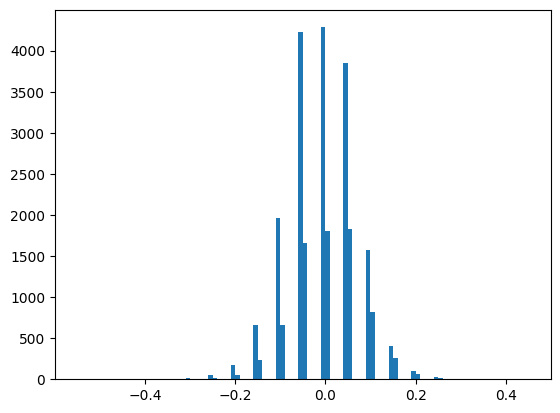

In [107]:
main(snr, mode)

plot


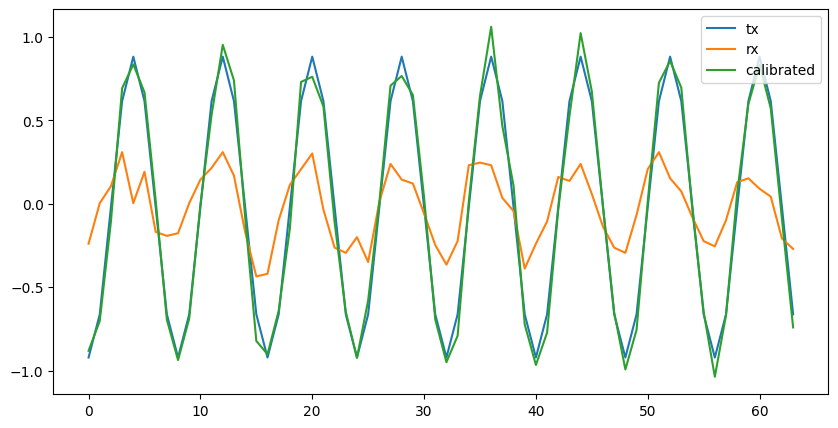

In [108]:
# the function to call this visual function
def test(snr, mode):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 1
    
    val_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/channel_equal.mat"
    val_cnn_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/hw_out_" + str(snr) + "db_" + mode + "_train_img.npy"
    val_dataset = channel_dataset(val_data_path, use_noise=True, is_train=False, cnn_out_path=val_cnn_path)
    val_sampler = data.SequentialSampler(val_dataset)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)

    train_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/channel_equal.mat"
    train_cnn_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/hw_out_" + str(snr) + "db_" + mode + "_train_img.npy"
    train_dataset = channel_dataset(train_data_path, use_noise=True, is_train=True, cnn_out_path=train_cnn_path)
    train_sampler = data.SequentialSampler(train_dataset)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
    
    model = Equalizer_MLP().to(device)
    # model_c = Equalizer_HW_after_CNN().to(device)

    model_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/best_model.pth"
    ckpt = torch.load(model_path)['model']
    model.load_state_dict(ckpt)
    model.eval()

    random_index = random.randint(0, len(val_loader.dataset) - 1)
    tx_input, rx_input = train_loader.dataset[random_index]
    rx = train_loader.dataset.trans(train_loader.dataset.rx_data_noised[random_index])
    tx_input, rx_input = tx_input.to(device).unsqueeze(0), rx_input.to(device).unsqueeze(0).to(torch.float)

    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            equalized_output = model(rx_input)

    tx_input = tx_input.cpu().numpy()
    equalized_output = equalized_output.cpu().numpy()
    print("plot")
    plt.figure(figsize=(10, 5))
    plt.plot(tx_input[0], label='tx')
    plt.plot(rx.view(-1,).cpu().numpy(), label='rx')
    plt.plot(equalized_output[0], label='calibrated')
    plt.legend()
    plt.show()

    dummy_rx = torch.randn(1, 1, 8, 16).to(device)
    # dummy_input = (dummy_tx_pilot, dummy_rx_pilot, dummy_rx)
    torch.onnx.export(model, dummy_rx,
                      "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/model_equalize_MLP_HW.onnx",
                      export_params=True, opset_version=16, dynamic_axes={'input': {0: 'batch_size'}, 'sensor_out': {0: 'batch_size'}},
                      input_names=['input'], output_names=['sensor_out'])

test(snr, mode)

In [101]:
# export model to onnx
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Equalizer().to(device)
model_HW = Equalizer_HW().to(device)

model_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/best_model.pth"
model.load_state_dict(torch.load(model_path)['model'])

cnn_state_dict = {k: v for k, v in model.state_dict().items() if k.startswith("equalizer.0") or k.startswith("equalizer.2") or k.startswith("equalizer.3") or k.startswith("equalizer.4") or k.startswith("equalizer.5") or k.startswith("equalizer.6")}
print(cnn_state_dict.keys())
model_HW.load_state_dict(cnn_state_dict)

for n, p in model_HW.named_parameters():
    if not torch.equal(p, cnn_state_dict[n]):
                print(f"Model and checkpoint parameters are not equal: model: {layer_name}")

# take the tx_pilot and rx_pilot from the dataset
train_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/channel_equal.mat"
train_dataset = channel_dataset(train_data_path, use_noise=True, is_train=True)
tx_pilot_train, rx_pilot_train = train_dataset.__get_pilot__()
tx_pilot_train, rx_pilot_train = tx_pilot_train.to(device), rx_pilot_train.to(device)

val_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/channel_equal.mat"
val_dataset = channel_dataset(val_data_path, use_noise=True, is_train=False)
tx_pilot_val, rx_pilot_val = val_dataset.__get_pilot__()
tx_pilot_val, rx_pilot_val = tx_pilot_val.to(device), rx_pilot_val.to(device)

model.eval()
model_HW.eval()
# model_HW.pilot_latent = nn.Parameter(model.pilot_encoder(torch.cat((tx_pilot, rx_pilot), dim=1)).clone().detach(), requires_grad=False)
# copy the model's equalizer parameter to model_HW's equalizer

with torch.no_grad():
    with torch.amp.autocast('cuda'):
        latent_vect_train = model.pilot_encoder(torch.cat((tx_pilot_train, rx_pilot_train), dim=1))
        latent_vect_val = model.pilot_encoder(torch.cat((tx_pilot_val, rx_pilot_val), dim=1))

rx_input_train = train_dataset.rx_data_noised / 255
latent_vect_train = latent_vect_train.reshape(1, 8, 8, 1).repeat(rx_input_train.shape[0], 1, 1, 1).cpu().detach().numpy() * 0.5 + 0.5

rx_input_val = val_dataset.rx_data_noised / 255
latent_vect_val = latent_vect_val.reshape(1, 8, 8, 1).repeat(rx_input_val.shape[0], 1, 1, 1).cpu().detach().numpy() * 0.5 + 0.5

rx_input_train = np.concatenate((latent_vect_train, rx_input_train), axis=2)
print(rx_input_train.shape)
tx_input_train = [train_dataset.trans(tx).view(1, -1).cpu().detach().numpy() for tx in train_dataset.tx_data]
tx_input_train = np.concatenate(tx_input_train)

rx_input_val = np.concatenate((latent_vect_val, rx_input_val), axis=2)
print(rx_input_val.shape)
tx_input_val = [val_dataset.trans(tx).view(1, -1).cpu().detach().numpy() for tx in val_dataset.tx_data]
tx_input_val = np.concatenate(tx_input_val)

# save the new rx_input and tx_input into a new .npz file
np.savez("./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/rx_input_for_HW_train.npz", rx_input=rx_input_train, tx_input=tx_input_train)
# np.savez("./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/shuffle/rx_input_for_HW_val.npz", rx_input=rx_input_val, tx_input=tx_input_val)

# dummy_tx_pilot = torch.randn(1, 1, 64, 64).to(device)
# dummy_rx_pilot = torch.randn(1, 1, 64, 64).to(device)
dummy_rx = torch.randn(1, 1, 8, 16).to(device)
# dummy_input = (dummy_tx_pilot, dummy_rx_pilot, dummy_rx)
torch.onnx.export(model_HW, dummy_rx,
                  "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/model_equalize_CNN_HW.onnx",
                  export_params=True, opset_version=16, dynamic_axes={'input': {0: 'batch_size'}, 'sensor_out': {0: 'batch_size'}},
                  input_names=['input'], output_names=['sensor_out'])

dict_keys(['equalizer.0.weight', 'equalizer.0.bias', 'equalizer.3.weight', 'equalizer.3.bias', 'equalizer.6.weight', 'equalizer.6.bias'])
(98304, 8, 16, 1)
(98304, 8, 16, 1)


In [24]:
def equalized_data(data_loader, model, data_set, device):
    tx_symbols, equalized_datas, tx_inputs, rx_inputs = data_set.symbols, [], data_set.tx_data, data_set.rx_data
    # take pilots
    tx_pilot, rx_pilot = data_loader.dataset.__get_pilot__()
    tx_pilot, rx_pilot = tx_pilot.to(device), rx_pilot.to(device)

    # expand pilots among the batch_size dim
    tx_pilot = tx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    rx_pilot = rx_pilot.expand(data_loader.batch_size, -1, -1, -1)
    
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            for tx, rx in data_loader:
                tx, rx = tx.to(device), rx.to(device)

                equalized_data = model(tx_pilot, rx_pilot, rx)
                equalized_datas.append(equalized_data)
    equalized_datas = torch.cat(equalized_datas, dim=0)

    # rescale the equalized_datas to [10, 240]
    equalized_datas = (equalized_datas - equalized_datas.min()) / (equalized_datas.max() - equalized_datas.min())  # Normalize to [0, 1]
    equalized_datas = equalized_datas * 230 + 10  # Scale to [10, 240]
    
    # add random int noise from [-3, +3] uniform dist, then clip the result in the range [0, 255]
    noise = torch.randint(-3, 4, equalized_datas.shape, device=device, dtype=equalized_data.dtype)
    equalized_datas = equalized_datas + noise
    equalized_datas = torch.clamp(equalized_datas, 0, 255).cpu().numpy()
    return tx_symbols, equalized_datas, tx_inputs, rx_inputs
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

val_data_path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/shuffle/channel_equal_val.mat"
val_dataset = channel_dataset(val_data_path, use_noise=True, is_train=False)
val_sampler = data.SequentialSampler(val_dataset)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, drop_last=False)

train_data_path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/shuffle/channel_equal_train.mat"
train_dataset = channel_dataset(train_data_path, use_noise=True, is_train=True)
train_sampler = data.SequentialSampler(train_dataset)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=False)

model = Equalizer().to(device)
model_path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/best_model.pth"
ckpt = torch.load(model_path)['model']
model.load_state_dict(ckpt)
model.eval()

tx_symbols, equalized_datas, tx_inputs, rx_inputs = equalized_data(train_loader, model, train_dataset, device)
path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/shuffle/equalized_data_train.mat" 
data_dict = {
    "tx_symbols": tx_symbols,
    "equalized_datas": equalized_datas,
    "tx_inputs": tx_inputs,
    "rx_inputs": rx_inputs
}
sio.savemat(path, data_dict)
# np.savez(path, rx_inputs=rx_inputs, tx_inputs=tx_inputs, tx_symbols=tx_symbols, equalized_datas=equalized_datas)

tx_symbols, equalized_datas, tx_inputs, rx_inputs = equalized_data(val_loader, model, val_dataset, device)
path = "./Symbol_Detection/channel_Rayleigh/" + str(snr) + "/" + mode + "/shuffle/equalized_data_val.mat" 
data_dict = {
    "tx_symbols": tx_symbols,
    "equalized_datas": equalized_datas,
    "tx_inputs": tx_inputs,
    "rx_inputs": rx_inputs
}
sio.savemat(path, data_dict)
# np.savez(path, rx_inputs=rx_inputs, tx_inputs=tx_inputs, tx_symbols=tx_symbols, equalized_datas=equalized_datas)

In [109]:
train_data_path = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/qam4_5db_img_mlp_hw_out.npy"
data = np.load(train_data_path)  # Load the NumPy array

# Define the MATLAB output file name
mat_file = "./Symbol_Detection/channel_Rayleigh/img/" + str(snr) + "/" + mode + "/qam4_5db_img_mlp_hw_out.mat"

# Save to .mat format
sio.savemat(mat_file, {"HW_data": data})  # Store as 'qam4_data' in MATLAB